## Librerías

In [1]:
#----------- Manejo y Visualizacion -----------#
import numpy as np
import pandas as pd
import boto3
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
#----------- Redes Neuronales -----------#
import tensorflow as tf
import tensorflow_hub as hub
#----------- Metricas y Entrenamiento -----------#
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
#----------- Warnings -----------#
import warnings
#----------- Funciones Creadas -----------#
from personal_functions import list_dataframes_train, prepare_data_image, pond_matriz, evaluate_model_class, graphs_train_models
#----------------------------------------------#
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
print(tf.__version__)
print(hub.__version__)
print(f'Numero GPUs disponibles: {len(tf.config.experimental.list_physical_devices("GPU"))}')

2.15.0
0.15.0
Numero GPUs disponibles: 0


## Conectando s3 Bucket y Data

Se borraran los nombres de buckets y carpetas.

In [ ]:
#Conectar con Bucket y carpetas
s3_bucket = boto3.client('s3')
bucket =
frontL_csv =
frontR_csv =

In [ ]:
#Dataframes L
objL = s3_bucket.get_object(Bucket = bucket, Key = frontL_csv)
dataL = pd.read_csv(objL['Body'])
dataL.imagen = dataL.imagen.apply(lambda string : 'frontL/' + string)
dataL.head()

,fecha,hora,polución,estanquedad,clima,imagen
0,2022-10-24,07:00:00,No,No,Neblina,frontL/imagen_0.jpg
1,2022-10-24,07:05:00,No,No,Neblina,frontL/imagen_1.jpg
2,2022-10-24,07:10:00,No,No,Neblina,frontL/imagen_2.jpg
3,2022-10-24,07:15:00,No,No,Neblina,frontL/imagen_3.jpg
4,2022-10-24,07:20:00,No,No,Neblina,frontL/imagen_4.jpg


In [ ]:
#Dataframes R
objR = s3_bucket.get_object(Bucket = bucket, Key = frontR_csv)
dataR = pd.read_csv(objR['Body'])
dataR.imagen = dataR.imagen.apply(lambda string : 'frontR/' + string)
dataR.head()

,fecha,hora,polución,estanquedad,clima,imagen
0,2022-10-24,07:00:00,No,No,Neblina,frontR/imagen_0.jpg
1,2022-10-24,07:05:00,No,No,Neblina,frontR/imagen_1.jpg
2,2022-10-24,07:10:00,No,No,Neblina,frontR/imagen_2.jpg
3,2022-10-24,07:15:00,No,No,Neblina,frontR/imagen_3.jpg
4,2022-10-24,07:20:00,No,No,Neblina,frontR/imagen_4.jpg


In [ ]:
#Unimos los dataframes
print(dataL.shape, dataR.shape)
data = pd.concat([dataL, dataR], ignore_index = True).sort_values(by = 'fecha', ascending = True).reset_index(drop = True)
print(data.shape)
del data['fecha'], data['hora']
data.head()

(39951, 6) (39220, 6)
(79171, 6)


,polución,estanquedad,clima,imagen
0,No,No,Neblina,frontL/imagen_0.jpg
1,No,Estancamiento,Despejado,frontR/imagen_55.jpg
2,Leve,Estancamiento,Despejado,frontR/imagen_54.jpg
3,Leve,Estancamiento,Despejado,frontR/imagen_53.jpg
4,Leve,Estancamiento,Despejado,frontR/imagen_52.jpg


In [ ]:
#Data mal etiquetada
data = data[(data.clima != 'Estancamiento') & (data.estanquedad != 'Leve')].copy()
data = data.dropna().reset_index(drop = True)
print(data.clima.unique())
print(data.estanquedad.unique())
print(data.shape)

['Neblina' 'Despejado' 'Nubosidad leve' 'Nubosidad alta']
['No' 'Estancamiento' 'Encapsulamiento']
(78845, 4)


In [ ]:
print(data.clima.value_counts(normalize = True))
print('--------------------------------------')
print(data.estanquedad.value_counts(normalize = True))
print('--------------------------------------')
print(data['polución'].value_counts(normalize = True))

clima
Despejado         0.601319
Nubosidad alta    0.148088
Nubosidad leve    0.131980
Neblina           0.118612
Name: proportion, dtype: float64
--------------------------------------
estanquedad
No                 0.526552
Estancamiento      0.468197
Encapsulamiento    0.005251
Name: proportion, dtype: float64
--------------------------------------
polución
No        0.575395
Leve      0.422487
Fuerte    0.002118
Name: proportion, dtype: float64


In [ ]:
#Conectamos con el folder que se quiere revisar
name_folder =
reponse = s3_bucket.list_objects(Bucket = bucket, Prefix = name_folder)
#Formamos lista para guardar los nombres
file_namesL = []
#Conectamos con objeto que contiene las paginas del bucket (en caso de tener muchos objetos, hay varias paginas)
paginator = s3_bucket.get_paginator('list_objects')
#Se conecta con todas las paginas
pages = paginator.paginate(Bucket = bucket, Prefix = name_folder)
#Se itera pagina por pagina
for page in pages:
    #Se revisa el contenido de la pagina
    contents = page.get('Contents', [])
    #Se itera archivo por archivo de la pagina
    for obj in contents:
        #Guardamos el nombre del archivo
        file_namesL.append(obj['Key'])

#Conectamos con el folder que se quiere revisar
name_folder =
reponse = s3_bucket.list_objects(Bucket = bucket, Prefix = name_folder)
#Formamos lista para guardar los nombres
file_namesR = []
#Conectamos con objeto que contiene las paginas del bucket (en caso de tener muchos objetos, hay varias paginas)
paginator = s3_bucket.get_paginator('list_objects')
#Se conecta con todas las paginas
pages = paginator.paginate(Bucket = bucket, Prefix = name_folder)
#Se itera pagina por pagina
for page in pages:
    #Se revisa el contenido de la pagina
    contents = page.get('Contents', [])
    #Se itera archivo por archivo de la pagina
    for obj in contents:
        #Guardamos el nombre del archivo
        file_namesR.append(obj['Key'])

file_names = file_namesL + file_namesR
print(len(file_names))

77978


In [ ]:
#Imagenes no presentes en S3, pero si en el dataframe
lista_not_images = []
for image in data.imagen:
    if image not in file_names:
        lista_not_images.append(image)
len(lista_not_images)

1197

In [ ]:
#Sacamos del dataframe imagenes faltantes
data = data[~data['imagen'].isin(lista_not_images)]
data.shape

(77648, 4)

In [ ]:
data.estanquedad = data.estanquedad.replace({'No' : 0, 'Estancamiento' : 1, 'Encapsulamiento' : 2})
_, _, _, _, _, _, _, _, df_test = list_dataframes_train(data, 'estanquedad')
del data, file_names, file_namesL, file_namesR, lista_not_images
print(df_test.shape)
df_test.head()

(9706, 2)


,imagen,estanquedad
0,frontR/imagen_12.jpg,0
1,frontR/imagen_5.jpg,0
2,frontR/imagen_120.jpg,0
3,frontR/imagen_137.jpg,0
4,frontR/imagen_145.jpg,0


## Modelo

In [ ]:
# Modelo pre entrenado hasta el Flatten (Modelo Inceptionv3)
url = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5'

#Congelamos sus parametros pre-entrenados
inception = hub.KerasLayer(url, input_shape = (224, 224, 3))
inception.trainable = False

Estanquedad = tf.keras.models.Sequential([
    #Usamos la red inception
    inception,
    #Densa
    tf.keras.layers.Dense(512, activation = 'relu'),
    #Dropout de 50%
    tf.keras.layers.Dropout(0.5),
    #Densa
    tf.keras.layers.Dense(128, activation = 'relu'),
    #Dropout de 50%
    tf.keras.layers.Dropout(0.3),
    #Densa con 3 neuronas softmax para clases
    tf.keras.layers.Dense(3, activation = "softmax")
    ])

#Compilación
Estanquedad.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'AUC'])
Estanquedad.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 22917923 (87.42 MB)
Trainable params: 1115

In [ ]:
#Parametros de Entrenamiento
EPOCHS = 100
rango_epocas = list(range(1, EPOCHS + 1))

#Early Stopping para evitar overfitting
patience_early = 15
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = patience_early, restore_best_weights = True)

In [ ]:
Estanquedad = tf.keras.models.load_model(('Modelo_Estanquedad_Ronda_6.h5'), custom_objects = {'KerasLayer' : hub.KerasLayer})

## Modelado

#### Ronda 1

Entrenando modelo...
Epoch 1/100
226/226 [==============================] - 241s 1s/step - loss: 0.7784 - accuracy: 0.5913 - auc: 0.8079 - val_loss: 0.6170 - val_accuracy: 0.7271 - val_auc: 0.8968
Epoch 2/100
226/226 [==============================] - 233s 1s/step - loss: 0.6416 - accuracy: 0.6724 - auc: 0.8647 - val_loss: 0.5637 - val_accuracy: 0.7451 - val_auc: 0.9129
Epoch 3/100
226/226 [==============================] - 232s 1s/step - loss: 0.6104 - accuracy: 0.6999 - auc: 0.8808 - val_loss: 0.5951 - val_accuracy: 0.7388 - val_auc: 0.9089
Epoch 4/100
226/226 [==============================] - 233s 1s/step - loss: 0.5905 - accuracy: 0.7089 - auc: 0.8887 - val_loss: 0.5537 - val_accuracy: 0.7529 - val_auc: 0.9157
Epoch 5/100
226/226 [==============================] - 233s 1s/step - loss: 0.5808 - accuracy: 0.7215 - auc: 0.8935 - val_loss: 0.5401 - val_accuracy: 0.7490 - val_auc: 0.9157
Epoch 6/100
226/226 [==============================] - 234s 1s/step - loss: 0.5738 - accuracy: 0.72

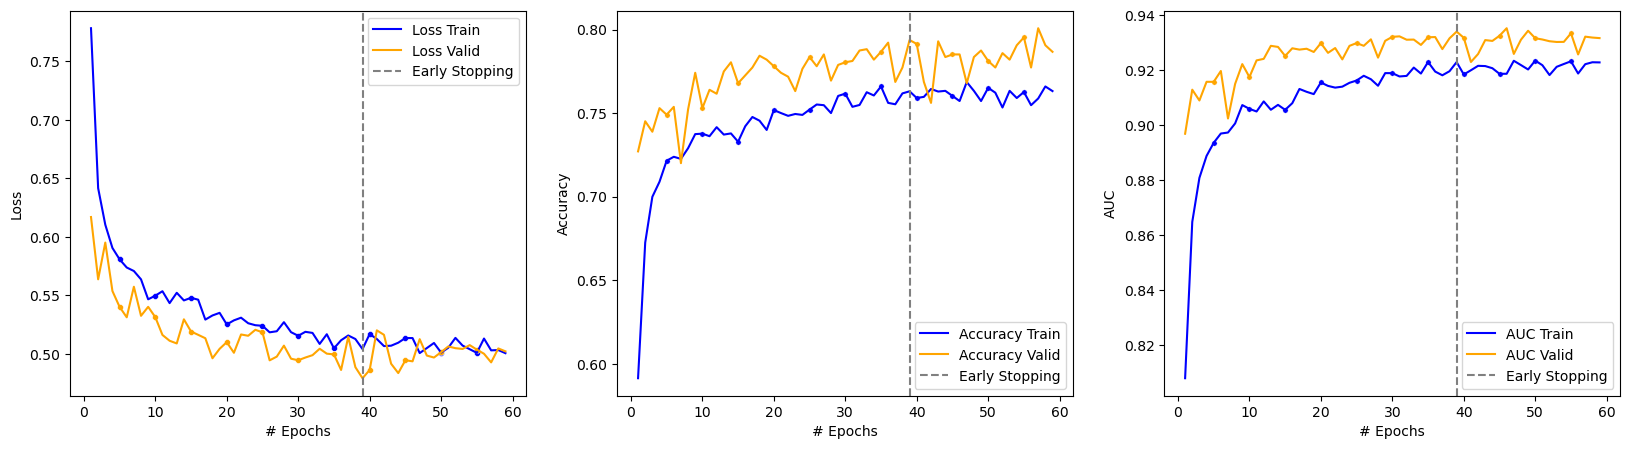

In [ ]:
X_train, X_val, y_train, y_val = prepare_data_image(df1, 'estanquedad', bucket, s3_bucket)

#Data Augmentation
datagen = ImageDataGenerator(shear_range = 0.15, zoom_range = [0.85, 1.1], horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1)
datagen.fit(X_train)
data_train = datagen.flow(X_train, y_train, batch_size = 32)

#Entrenamiento
print("Entrenando modelo...");
historial = Estanquedad.fit(data_train, epochs = EPOCHS, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Estanquedad.save('Modelo_Estanquedad_Ronda_1.h5')
print('Estanquedad Model Saved!')

#Graficos
graphs_train_models(historial, patience_early, metric1 = 'accuracy', metric2 = 'AUC')

del X_train, X_val, y_train, y_val, datagen, data_train, df1, historial

#### Ronda 2

Entrenando modelo...
Epoch 1/100
226/226 [==============================] - 235s 1s/step - loss: 0.5126 - accuracy: 0.7510 - auc: 0.9189 - val_loss: 0.5061 - val_accuracy: 0.7671 - val_auc: 0.9244
Epoch 2/100
226/226 [==============================] - 233s 1s/step - loss: 0.5054 - accuracy: 0.7566 - auc: 0.9215 - val_loss: 0.4735 - val_accuracy: 0.7843 - val_auc: 0.9339
Epoch 3/100
226/226 [==============================] - 233s 1s/step - loss: 0.5034 - accuracy: 0.7650 - auc: 0.9226 - val_loss: 0.4865 - val_accuracy: 0.7835 - val_auc: 0.9313
Epoch 4/100
226/226 [==============================] - 233s 1s/step - loss: 0.5076 - accuracy: 0.7596 - auc: 0.9212 - val_loss: 0.5051 - val_accuracy: 0.7765 - val_auc: 0.9290
Epoch 5/100
226/226 [==============================] - 233s 1s/step - loss: 0.5055 - accuracy: 0.7633 - auc: 0.9222 - val_loss: 0.5236 - val_accuracy: 0.7851 - val_auc: 0.9278
Epoch 6/100
226/226 [==============================] - 232s 1s/step - loss: 0.5099 - accuracy: 0.76

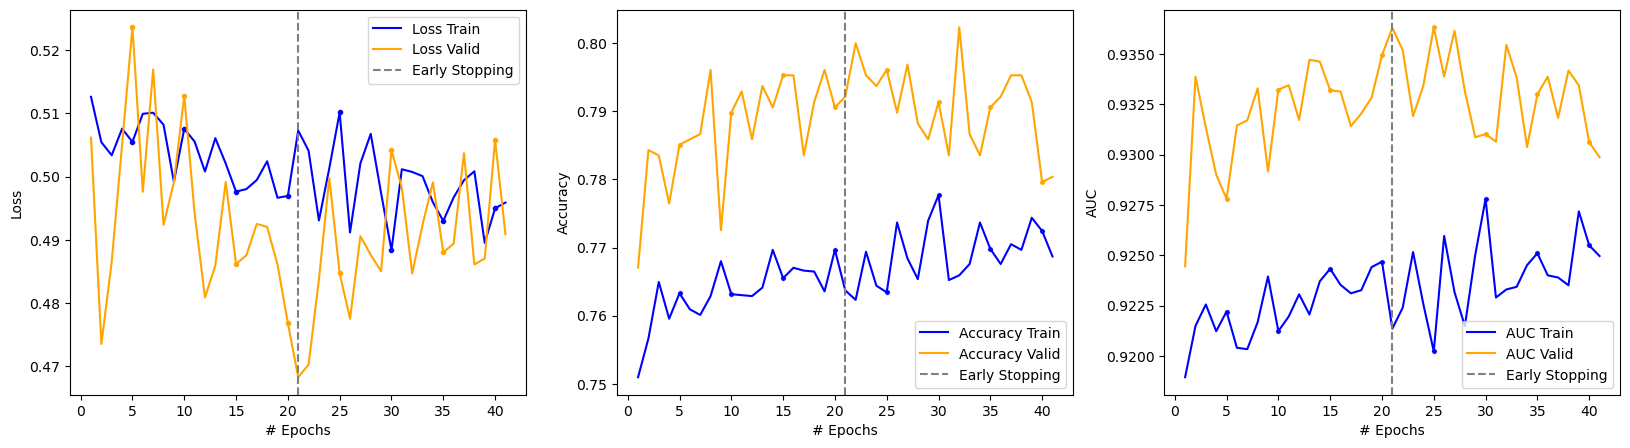

In [ ]:
X_train, X_val, y_train, y_val = prepare_data_image(df2, 'estanquedad', bucket, s3_bucket)

#Data Augmentation
datagen = ImageDataGenerator(shear_range = 0.15, zoom_range = [0.85, 1.1], horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1)
datagen.fit(X_train)
data_train = datagen.flow(X_train, y_train, batch_size = 32)

#Entrenamiento
print("Entrenando modelo...");
historial = Estanquedad.fit(data_train, epochs = EPOCHS, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Estanquedad.save('Modelo_Estanquedad_Ronda_2.h5')
print('Estanquedad Model Saved!')

#Graficos
graphs_train_models(historial, patience_early, metric1 = 'accuracy', metric2 = 'AUC')

del X_train, X_val, y_train, y_val, datagen, data_train, df2, historial

#### Ronda 3

Entrenando modelo...
Epoch 1/100
226/226 [==============================] - 237s 1s/step - loss: 0.5065 - accuracy: 0.7633 - auc: 0.9212 - val_loss: 0.4924 - val_accuracy: 0.7984 - val_auc: 0.9374
Epoch 2/100
226/226 [==============================] - 230s 1s/step - loss: 0.4958 - accuracy: 0.7747 - auc: 0.9254 - val_loss: 0.4803 - val_accuracy: 0.8031 - val_auc: 0.9372
Epoch 3/100
226/226 [==============================] - 230s 1s/step - loss: 0.5023 - accuracy: 0.7643 - auc: 0.9228 - val_loss: 0.4954 - val_accuracy: 0.7914 - val_auc: 0.9353
Epoch 4/100
226/226 [==============================] - 230s 1s/step - loss: 0.4909 - accuracy: 0.7783 - auc: 0.9270 - val_loss: 0.4795 - val_accuracy: 0.7961 - val_auc: 0.9342
Epoch 5/100
226/226 [==============================] - 230s 1s/step - loss: 0.4955 - accuracy: 0.7691 - auc: 0.9252 - val_loss: 0.4956 - val_accuracy: 0.8000 - val_auc: 0.9331
Epoch 6/100
226/226 [==============================] - 230s 1s/step - loss: 0.4912 - accuracy: 0.77

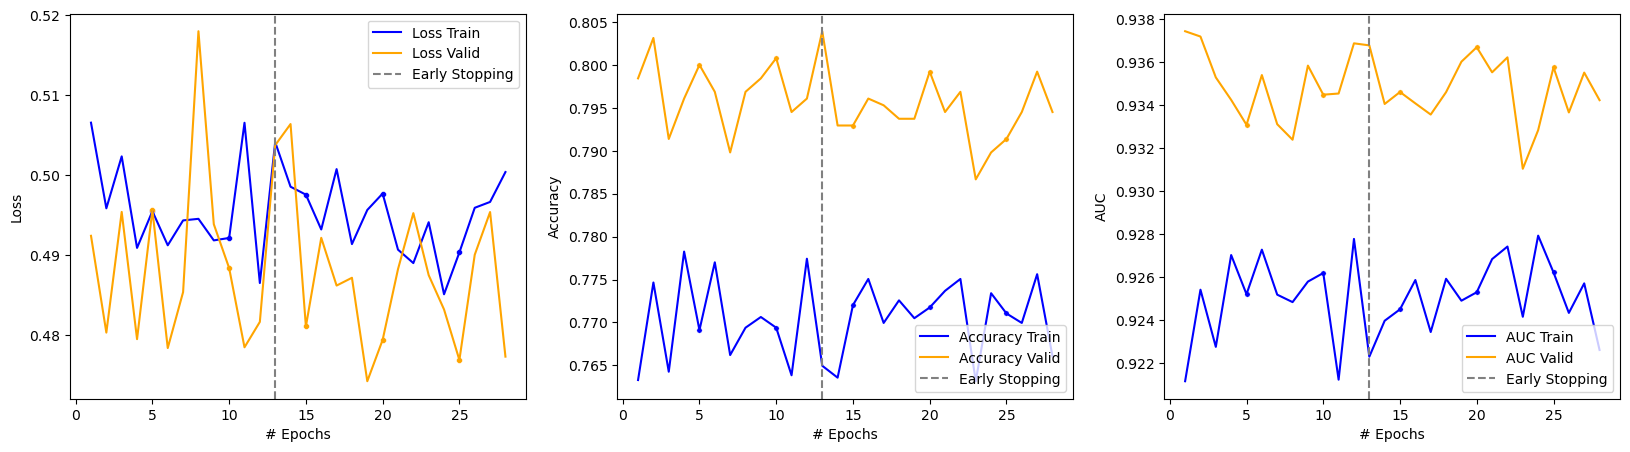

In [ ]:
X_train, X_val, y_train, y_val = prepare_data_image(df3, 'estanquedad', bucket, s3_bucket)

#Data Augmentation
datagen = ImageDataGenerator(shear_range = 0.15, zoom_range = [0.85, 1.1], horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1)
datagen.fit(X_train)
data_train = datagen.flow(X_train, y_train, batch_size = 32)

#Entrenamiento
print("Entrenando modelo...");
historial = Estanquedad.fit(data_train, epochs = EPOCHS, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Estanquedad.save('Modelo_Estanquedad_Ronda_3.h5')
print('Estanquedad Model Saved!')

#Graficos
graphs_train_models(historial, patience_early, metric1 = 'accuracy', metric2 = 'AUC')

del X_train, X_val, y_train, y_val, datagen, data_train, df3, historial

#### Ronda 4

Entrenando modelo...
Epoch 1/100
226/226 [==============================] - 245s 1s/step - loss: 0.5024 - accuracy: 0.7650 - auc: 0.9224 - val_loss: 0.4756 - val_accuracy: 0.7898 - val_auc: 0.9348
Epoch 2/100
226/226 [==============================] - 235s 1s/step - loss: 0.4980 - accuracy: 0.7679 - auc: 0.9237 - val_loss: 0.4782 - val_accuracy: 0.7890 - val_auc: 0.9332
Epoch 3/100
226/226 [==============================] - 235s 1s/step - loss: 0.5003 - accuracy: 0.7699 - auc: 0.9239 - val_loss: 0.4808 - val_accuracy: 0.7937 - val_auc: 0.9316
Epoch 4/100
226/226 [==============================] - 235s 1s/step - loss: 0.5044 - accuracy: 0.7702 - auc: 0.9229 - val_loss: 0.4857 - val_accuracy: 0.7914 - val_auc: 0.9335
Epoch 5/100
226/226 [==============================] - 236s 1s/step - loss: 0.4943 - accuracy: 0.7777 - auc: 0.9261 - val_loss: 0.4938 - val_accuracy: 0.7976 - val_auc: 0.9329
Epoch 6/100
226/226 [==============================] - 236s 1s/step - loss: 0.4952 - accuracy: 0.76

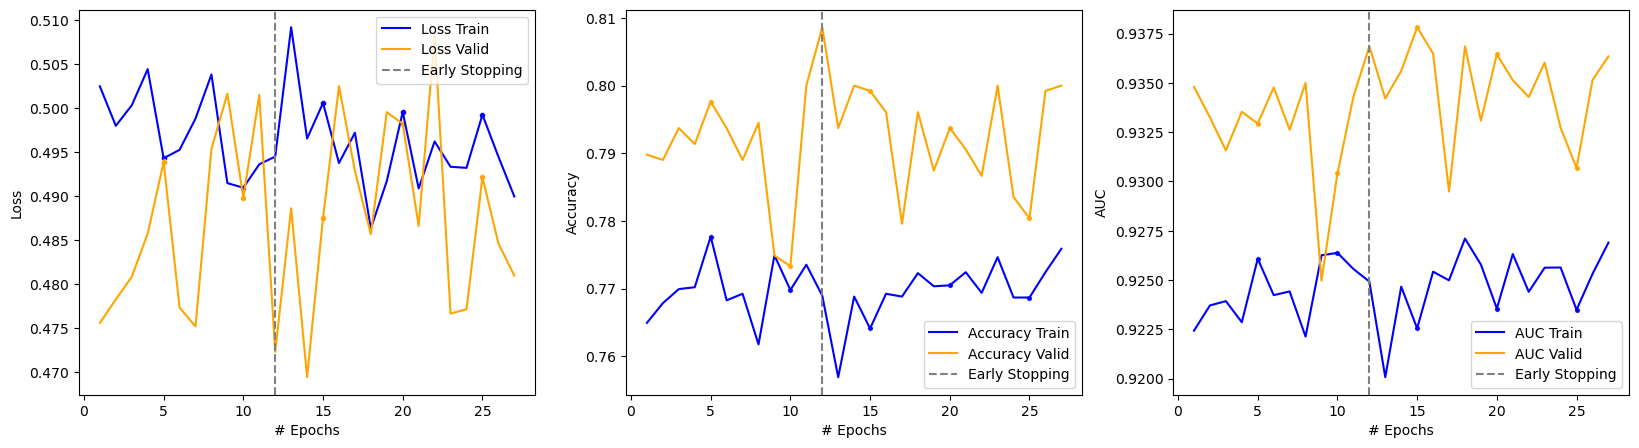

In [ ]:
X_train, X_val, y_train, y_val = prepare_data_image(df4, 'estanquedad', bucket, s3_bucket)

#Data Augmentation
datagen = ImageDataGenerator(shear_range = 0.15, zoom_range = [0.85, 1.1], horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1)
datagen.fit(X_train)
data_train = datagen.flow(X_train, y_train, batch_size = 32)

#Entrenamiento
print("Entrenando modelo...");
historial = Estanquedad.fit(data_train, epochs = EPOCHS, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Estanquedad.save('Modelo_Estanquedad_Ronda_4.h5')
print('Estanquedad Model Saved!')

#Graficos
graphs_train_models(historial, patience_early, metric1 = 'accuracy', metric2 = 'AUC')

del X_train, X_val, y_train, y_val, datagen, data_train, df4, historial

#### Ronda 5

Entrenando modelo...
Epoch 1/100
226/226 [==============================] - 240s 1s/step - loss: 0.5006 - accuracy: 0.7657 - auc: 0.9232 - val_loss: 0.4902 - val_accuracy: 0.8039 - val_auc: 0.9372
Epoch 2/100
226/226 [==============================] - 233s 1s/step - loss: 0.4971 - accuracy: 0.7672 - auc: 0.9234 - val_loss: 0.4772 - val_accuracy: 0.7906 - val_auc: 0.9345
Epoch 3/100
226/226 [==============================] - 233s 1s/step - loss: 0.4981 - accuracy: 0.7669 - auc: 0.9235 - val_loss: 0.4770 - val_accuracy: 0.7922 - val_auc: 0.9353
Epoch 4/100
226/226 [==============================] - 232s 1s/step - loss: 0.4975 - accuracy: 0.7636 - auc: 0.9241 - val_loss: 0.4821 - val_accuracy: 0.8055 - val_auc: 0.9370
Epoch 5/100
226/226 [==============================] - 233s 1s/step - loss: 0.5002 - accuracy: 0.7690 - auc: 0.9231 - val_loss: 0.5031 - val_accuracy: 0.7804 - val_auc: 0.9313
Epoch 6/100
226/226 [==============================] - 233s 1s/step - loss: 0.4964 - accuracy: 0.77

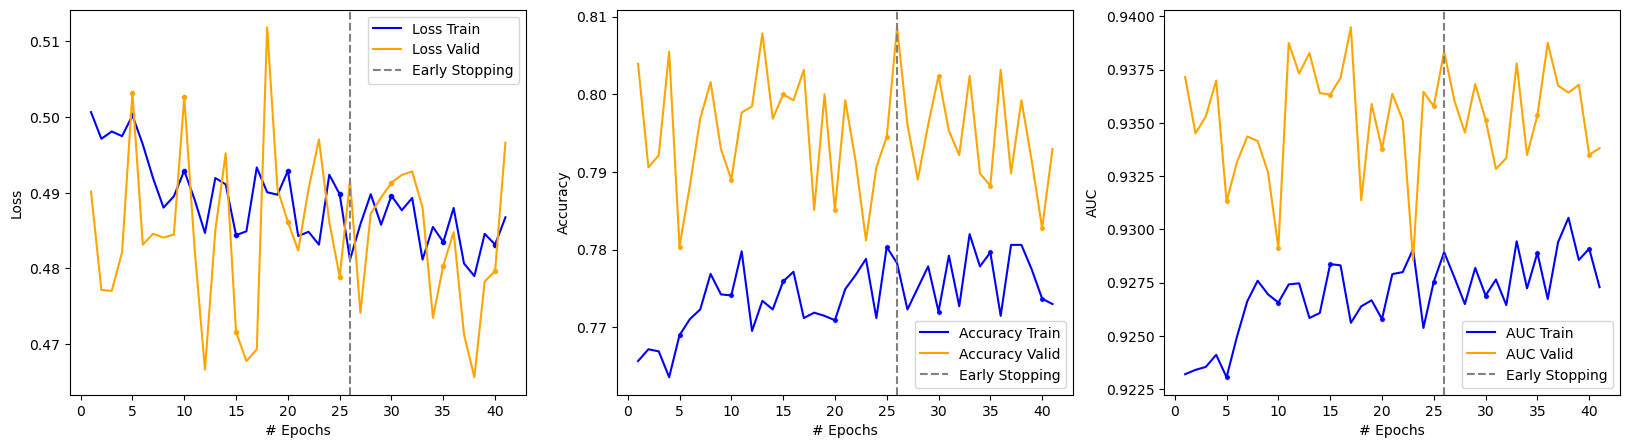

In [ ]:
X_train, X_val, y_train, y_val = prepare_data_image(df5, 'estanquedad', bucket, s3_bucket)

#Data Augmentation
datagen = ImageDataGenerator(shear_range = 0.15, zoom_range = [0.85, 1.1], horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1)
datagen.fit(X_train)
data_train = datagen.flow(X_train, y_train, batch_size = 32)

#Entrenamiento
print("Entrenando modelo...");
historial = Estanquedad.fit(data_train, epochs = EPOCHS, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Estanquedad.save('Modelo_Estanquedad_Ronda_5.h5')
print('Estanquedad Model Saved!')

#Graficos
graphs_train_models(historial, patience_early, metric1 = 'accuracy', metric2 = 'AUC')

del X_train, X_val, y_train, y_val, datagen, data_train, df5, historial

#### Ronda 6

Entrenando modelo...
Epoch 1/100
226/226 [==============================] - 239s 1s/step - loss: 0.4856 - accuracy: 0.7727 - auc: 0.9281 - val_loss: 0.5032 - val_accuracy: 0.7875 - val_auc: 0.9318
Epoch 2/100
226/226 [==============================] - 232s 1s/step - loss: 0.4784 - accuracy: 0.7827 - auc: 0.9304 - val_loss: 0.5044 - val_accuracy: 0.7859 - val_auc: 0.9298
Epoch 3/100
226/226 [==============================] - 232s 1s/step - loss: 0.4900 - accuracy: 0.7697 - auc: 0.9262 - val_loss: 0.4756 - val_accuracy: 0.8024 - val_auc: 0.9348
Epoch 4/100
226/226 [==============================] - 232s 1s/step - loss: 0.4825 - accuracy: 0.7774 - auc: 0.9288 - val_loss: 0.4910 - val_accuracy: 0.7984 - val_auc: 0.9381
Epoch 5/100
226/226 [==============================] - 232s 1s/step - loss: 0.4929 - accuracy: 0.7755 - auc: 0.9266 - val_loss: 0.4903 - val_accuracy: 0.8039 - val_auc: 0.9360
Epoch 6/100
226/226 [==============================] - 232s 1s/step - loss: 0.4901 - accuracy: 0.76

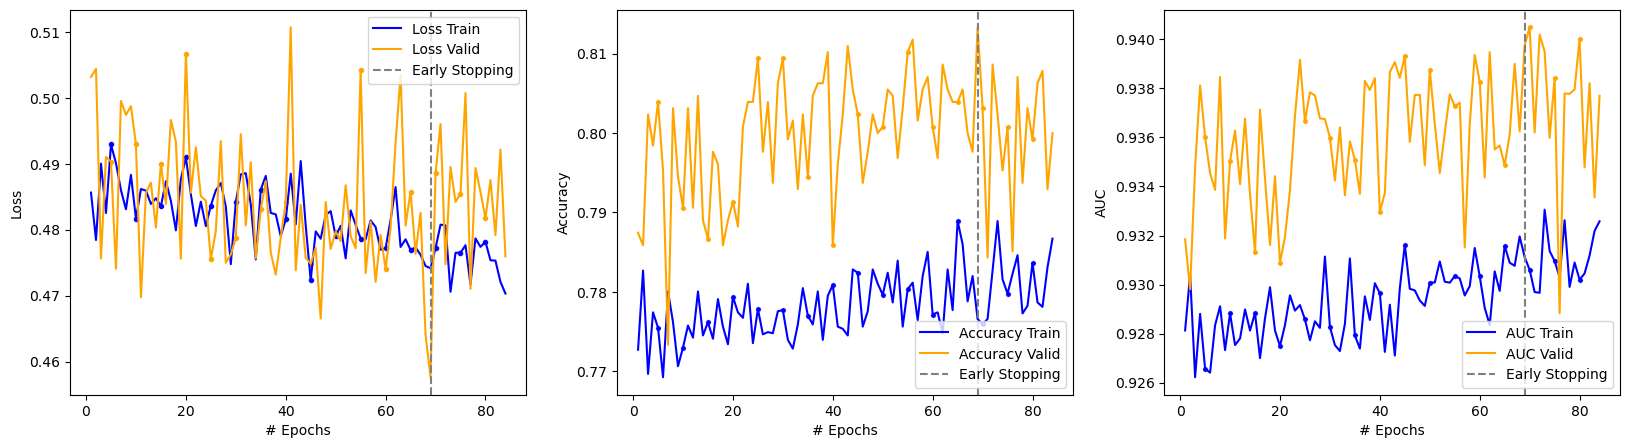

In [ ]:
X_train, X_val, y_train, y_val = prepare_data_image(df6, 'estanquedad', bucket, s3_bucket)

#Data Augmentation
datagen = ImageDataGenerator(shear_range = 0.15, zoom_range = [0.85, 1.1], horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1)
datagen.fit(X_train)
data_train = datagen.flow(X_train, y_train, batch_size = 32)

#Entrenamiento
print("Entrenando modelo...");
historial = Estanquedad.fit(data_train, epochs = EPOCHS, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Estanquedad.save('Modelo_Estanquedad_Ronda_6.h5')
print('Estanquedad Model Saved!')

#Graficos
graphs_train_models(historial, patience_early, metric1 = 'accuracy', metric2 = 'AUC')

del X_train, X_val, y_train, y_val, datagen, data_train, df6, historial

#### Ronda 7

Entrenando modelo...
Epoch 1/100
226/226 [==============================] - 145s 623ms/step - loss: 0.4788 - accuracy: 0.7845 - auc: 0.9308 - val_loss: 0.4740 - val_accuracy: 0.8078 - val_auc: 0.9392
Epoch 2/100
226/226 [==============================] - 127s 560ms/step - loss: 0.4751 - accuracy: 0.7765 - auc: 0.9310 - val_loss: 0.4697 - val_accuracy: 0.8016 - val_auc: 0.9388
Epoch 3/100
226/226 [==============================] - 146s 643ms/step - loss: 0.4790 - accuracy: 0.7831 - auc: 0.9307 - val_loss: 0.4972 - val_accuracy: 0.8008 - val_auc: 0.9351
Epoch 4/100
226/226 [==============================] - 145s 642ms/step - loss: 0.4863 - accuracy: 0.7765 - auc: 0.9278 - val_loss: 0.4614 - val_accuracy: 0.8039 - val_auc: 0.9372
Epoch 5/100
226/226 [==============================] - 145s 643ms/step - loss: 0.4744 - accuracy: 0.7849 - auc: 0.9318 - val_loss: 0.4703 - val_accuracy: 0.8031 - val_auc: 0.9388
Epoch 6/100
226/226 [==============================] - 146s 644ms/step - loss: 0.470

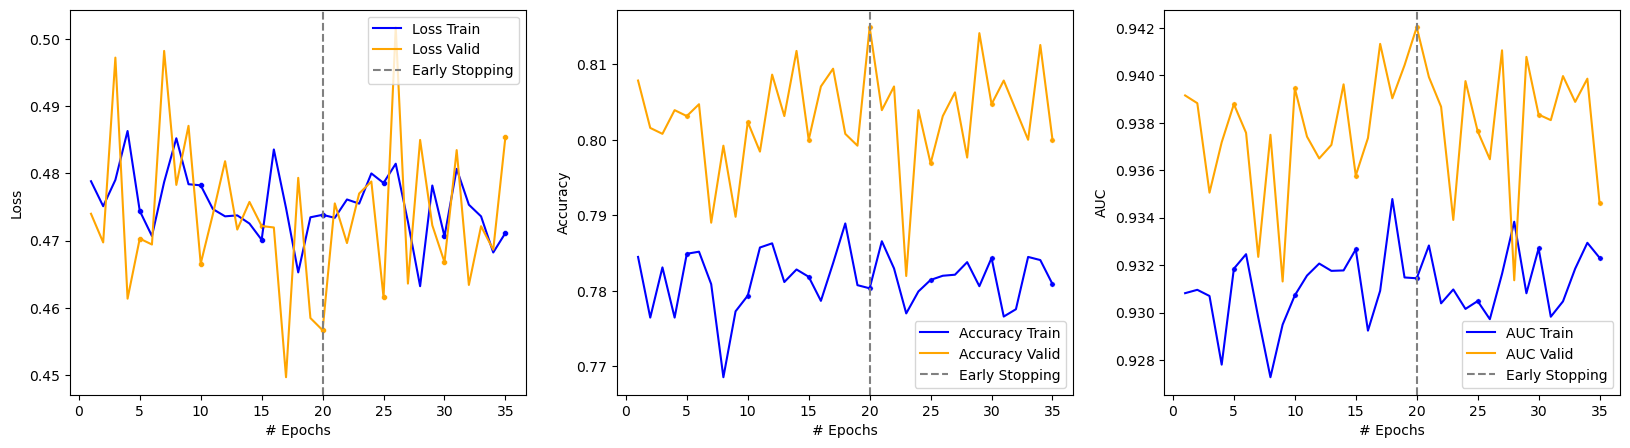

In [ ]:
X_train, X_val, y_train, y_val = prepare_data_image(df7, 'estanquedad', bucket, s3_bucket)

#Data Augmentation
datagen = ImageDataGenerator(shear_range = 0.15, zoom_range = [0.85, 1.1], horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1)
datagen.fit(X_train)
data_train = datagen.flow(X_train, y_train, batch_size = 32)

#Entrenamiento
print("Entrenando modelo...");
historial = Estanquedad.fit(data_train, epochs = EPOCHS, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Estanquedad.save('Modelo_Estanquedad_Ronda_7.h5')
print('Estanquedad Model Saved!')

#Graficos
graphs_train_models(historial, patience_early, metric1 = 'accuracy', metric2 = 'AUC')

del X_train, X_val, y_train, y_val, datagen, data_train, df7, historial

#### Ronda 8

Entrenando modelo...
Epoch 1/100
226/226 [==============================] - 146s 644ms/step - loss: 0.4662 - accuracy: 0.7877 - auc: 0.9335 - val_loss: 0.4554 - val_accuracy: 0.8047 - val_auc: 0.9401
Epoch 2/100
226/226 [==============================] - 145s 643ms/step - loss: 0.4743 - accuracy: 0.7830 - auc: 0.9314 - val_loss: 0.4645 - val_accuracy: 0.7992 - val_auc: 0.9385
Epoch 3/100
226/226 [==============================] - 145s 643ms/step - loss: 0.4817 - accuracy: 0.7788 - auc: 0.9293 - val_loss: 0.4619 - val_accuracy: 0.8016 - val_auc: 0.9369
Epoch 4/100
226/226 [==============================] - 145s 643ms/step - loss: 0.4722 - accuracy: 0.7813 - auc: 0.9321 - val_loss: 0.4898 - val_accuracy: 0.8102 - val_auc: 0.9380
Epoch 5/100
226/226 [==============================] - 145s 643ms/step - loss: 0.4736 - accuracy: 0.7849 - auc: 0.9321 - val_loss: 0.4808 - val_accuracy: 0.7984 - val_auc: 0.9371
Epoch 6/100
226/226 [==============================] - 146s 644ms/step - loss: 0.473

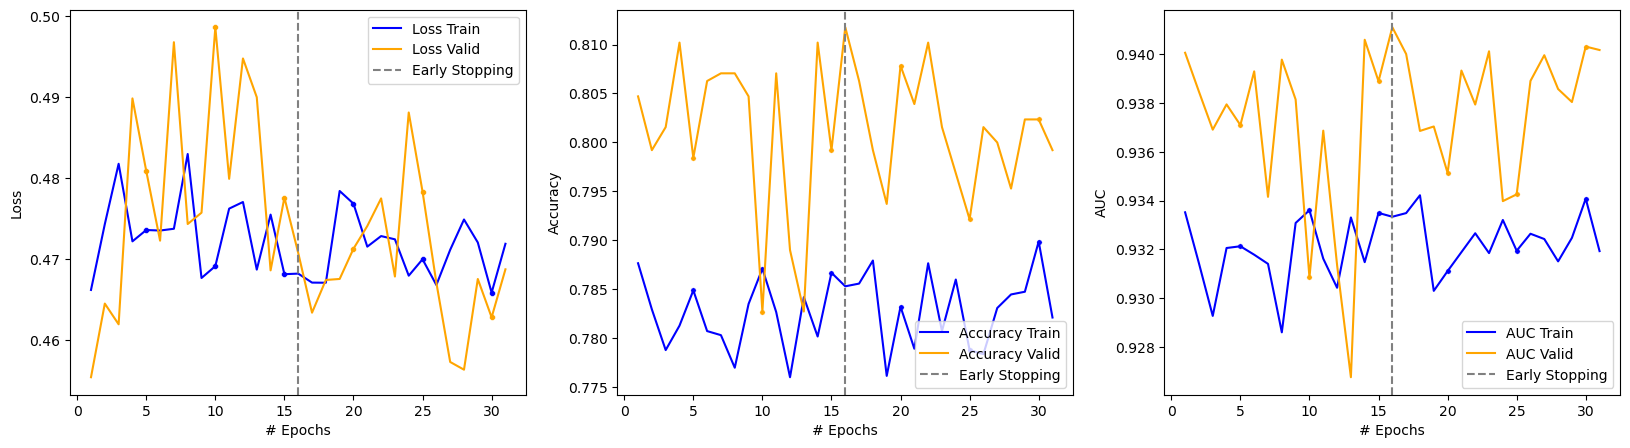

In [ ]:
X_train, X_val, y_train, y_val = prepare_data_image(df8, 'estanquedad', bucket, s3_bucket)

#Data Augmentation
datagen = ImageDataGenerator(shear_range = 0.15, zoom_range = [0.85, 1.1], horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1)
datagen.fit(X_train)
data_train = datagen.flow(X_train, y_train, batch_size = 32)

#Entrenamiento
print("Entrenando modelo...");
historial = Estanquedad.fit(data_train, epochs = EPOCHS, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Estanquedad.save('Modelo_Estanquedad_Ronda_8.h5')
print('Estanquedad Model Saved!')

#Graficos
graphs_train_models(historial, patience_early, metric1 = 'accuracy', metric2 = 'AUC')

del X_train, X_val, y_train, y_val, datagen, data_train, df8, historial

#### Evaluando Modelo

213/213 [==============================] - 102s 477ms/step
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      3571
           1       0.78      0.82      0.80      3186
           2       0.00      0.00      0.00        37

    accuracy                           0.81      6794
   macro avg       0.54      0.54      0.54      6794
weighted avg       0.80      0.81      0.80      6794



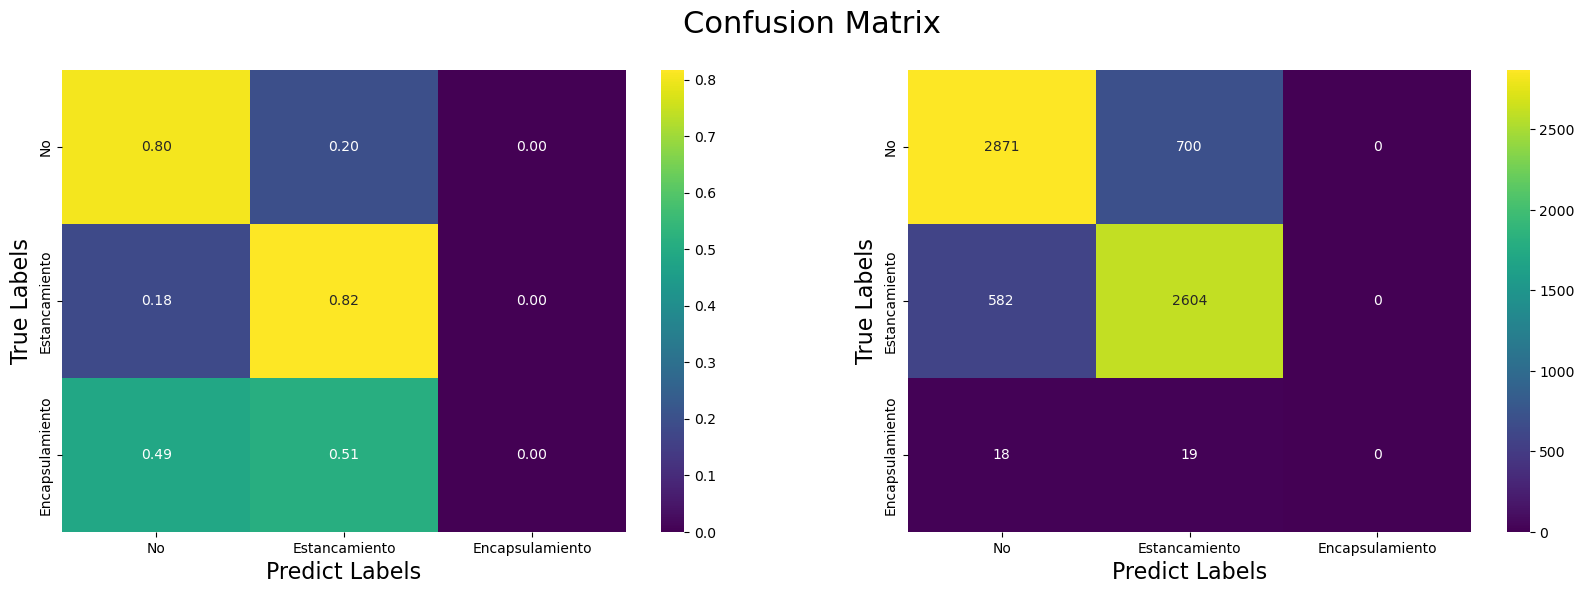

In [ ]:
X_test, _, y_test, _ = prepare_data_image(df_test, 'estanquedad', bucket, s3_bucket, percent_test = .3)
etiquetas = ['No', 'Estancamiento', 'Encapsulamiento']
y_test = np.argmax(y_test, axis = 1)

del Estanquedad
Estanquedad = tf.keras.models.load_model(('Modelo_Estanquedad_Ronda_8.h5'), custom_objects = {'KerasLayer' : hub.KerasLayer})

evaluate_model_class(Estanquedad, X_test, y_test, etiquetas)

213/213 [==============================] - 102s 476ms/step
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      3571
           1       0.79      0.58      0.67      3186
           2       0.12      0.19      0.14        37

    accuracy                           0.72      6794
   macro avg       0.53      0.54      0.52      6794
weighted avg       0.73      0.72      0.71      6794



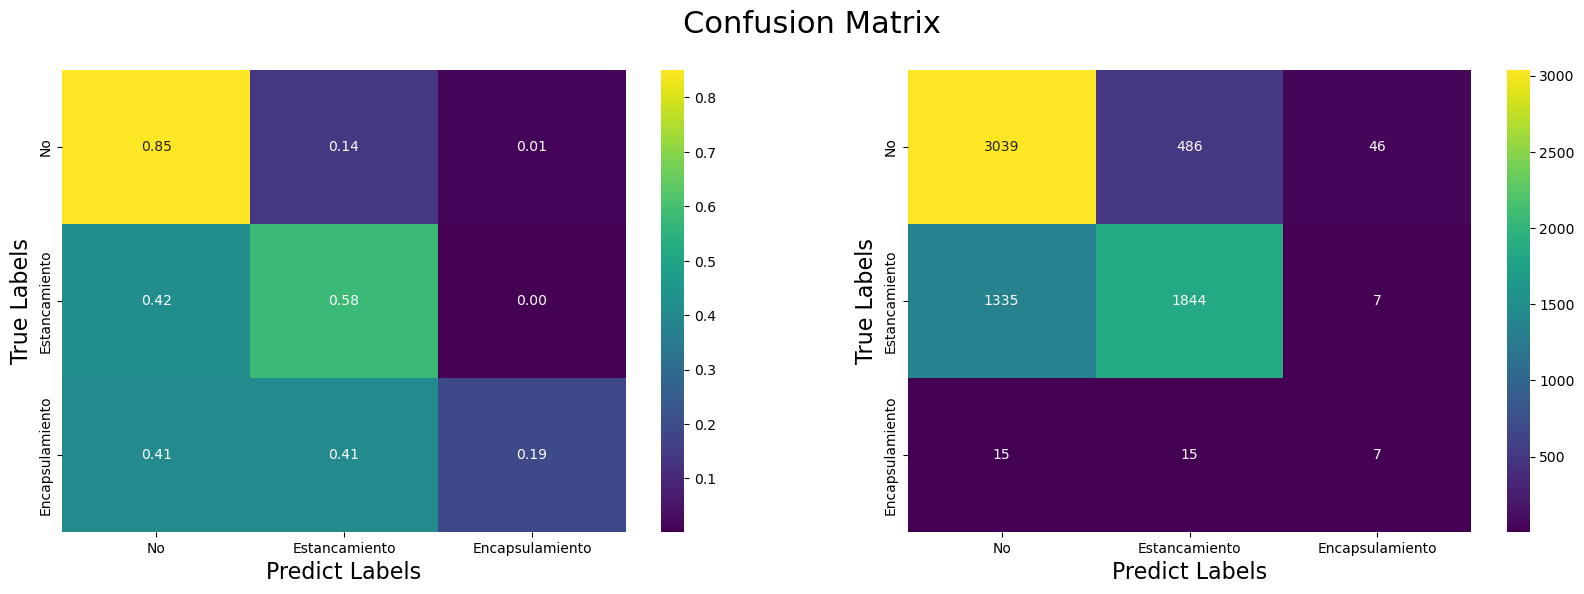

In [ ]:
#Modelo base (Modelo anterior)
X_test, _, y_test, _ = prepare_data_image(df_test, 'estanquedad', bucket, s3_bucket, flag_bgr = 1, percent_test = .3)
etiquetas = ['No', 'Estancamiento', 'Encapsulamiento']
y_test = np.argmax(y_test, axis = 1)

Estanquedad = tf.keras.models.load_model(('Estanquedad_fronts.h5'), custom_objects = {'KerasLayer' : hub.KerasLayer})

evaluate_model_class(Estanquedad, X_test, y_test, etiquetas)